# Datawhale 零基础入门数据挖掘-Task3 特征工程¶

## 三、 特征工程目标

Tip:此部分为零基础入门数据挖掘的 Task3 特征工程 部分，带你来了解各种特征工程以及分析方法，欢迎大家后续多多交流。

**赛题：零基础入门数据挖掘 - 二手车交易价格预测**

地址：https://tianchi.aliyun.com/competition/entrance/231784/introduction?spm=5176.12281957.1004.1.38b02448ausjSX 

## 3.1 特征工程目标
对于特征进行进一步分析，并对于数据进行处理

完成对于特征工程的分析，并对于数据进行一些图表或者文字总结并打卡。


## 3.2  内容介绍
常见的特征工程包括：
1. 异常处理：
    - 通过箱线图（或 3-Sigma）分析删除异常值；
    - BOX-COX 转换（处理有偏分布）；
    - 长尾截断；
2. 特征归一化/标准化：
    - 标准化（转换为标准正态分布）；
    - 归一化（抓换到 [0,1] 区间）；
    - 针对幂律分布，可以采用公式： $log(\frac{1+x}{1+median})$
3. 数据分桶：
    - 等频分桶；
    - 等距分桶；
    - Best-KS 分桶（类似利用基尼指数进行二分类）；
    - 卡方分桶；
4. 缺失值处理：
    - 不处理（针对类似 XGBoost 等树模型）；
    - 删除（缺失数据太多）；
    - 插值补全，包括均值/中位数/众数/建模预测/多重插补/压缩感知补全/矩阵补全等；
    - 分箱，缺失值一个箱；
5. 特征构造：
    - 构造统计量特征，报告计数、求和、比例、标准差等；
    - 时间特征，包括相对时间和绝对时间，节假日，双休日等；
    - 地理信息，包括分箱，分布编码等方法；
    - 非线性变换，包括 log/ 平方/ 根号等；
    - 特征组合，特征交叉；
    - 仁者见仁，智者见智。
6. 特征筛选
    - 过滤式（filter）：先对数据进行特征选择，然后在训练学习器，常见的方法有 Relief/方差选择发/相关系数法/卡方检验法/互信息法；
    - 包裹式（wrapper）：直接把最终将要使用的学习器的性能作为特征子集的评价准则，常见方法有 LVM（Las Vegas Wrapper） ；
    - 嵌入式（embedding）：结合过滤式和包裹式，学习器训练过程中自动进行了特征选择，常见的有 lasso 回归；
7. 降维
    - PCA/ LDA/ ICA；
    - 特征选择也是一种降维。

## 3.3 代码示例

## 3.3.0 导入数据

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

%matplotlib inline

In [3]:
Train_data = pd.read_csv('data/used_car_train_20200313.csv', sep=' ')
Test_data = pd.read_csv('data/used_car_testB_20200421.csv', sep=' ')
print(Train_data.shape)
print(Test_data.shape)

(150000, 31)
(50000, 30)


In [4]:
Train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [5]:
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [6]:
Test_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14'],
      dtype='object')

## 3.3.1 删除异常值

In [84]:
# 这里我包装了一个异常值处理的代码，可以随便调用。
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    # data_n保存删除异常值后的数据
    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    
    # 打印小于val_low的值
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    
    # 打印大于val_high的值
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


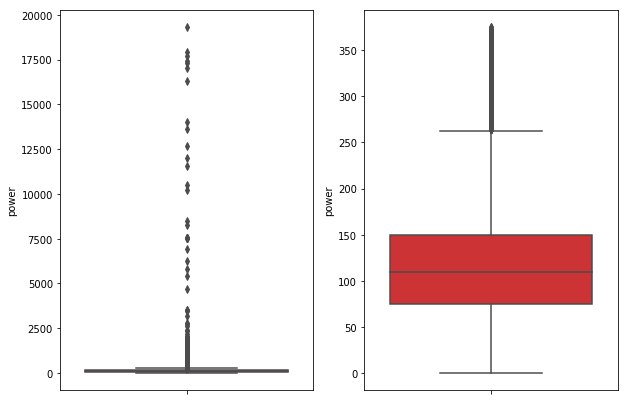

In [85]:
# 我们可以删掉一些异常数据，以 power 为例。  
# 这里删不删同学可以自行判断
# 但是要注意 test 的数据不能删 = = 不能掩耳盗铃是不是

Train_data = outliers_proc(Train_data, 'power', scale=3)

## 3.3.2 特征构造

concat(), append(), merge()一般都是用来连接两个或者多个DataFrame对象。其中， concat(), append()默认用来纵向连接DataFrame对象， merge()用来横向连接DataFrame对象。

In [7]:
# 训练集和测试集放在一起，方便构造特征
Train_data['train']=1
Test_data['train']=0
data = pd.concat([Train_data, Test_data], ignore_index=True)

In [8]:
# 使用时间：data['creatDate'] - data['regDate']，反应汽车使用时间，一般来说价格与使用时间成反比
# 不过要注意，数据里有时间出错的格式，所以我们需要 errors='coerce'
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

In [9]:
# 看一下空数据，有 15k 个样本的时间是有问题的，我们可以选择删除，也可以选择放着。
# 但是这里不建议删除，因为删除缺失数据占总样本量过大，7.5%
# 我们可以先放着，因为如果我们 XGBoost 之类的决策树，其本身就能处理缺失值，所以可以不用管；
data['used_time'].isnull().sum()

15083

In [9]:
# 从邮编中提取城市信息，相当于加入了先验知识
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])
data = data

In [10]:
# 计算某品牌的销售统计量，同学们还可以计算其他特征的统计量
# 这里要以 train 的数据计算统计量
Train_gb = Train_data.groupby("brand")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')

In [11]:
# 数据分桶 以 power 为例
# 这时候我们的缺失值也进桶了，
# 为什么要做数据分桶呢，原因有很多，= =
# 1. 离散后稀疏向量内积乘法运算速度更快，计算结果也方便存储，容易扩展；
# 2. 离散后的特征对异常值更具鲁棒性，如 age>30 为 1 否则为 0，对于年龄为 200 的也不会对模型造成很大的干扰；
# 3. LR 属于广义线性模型，表达能力有限，经过离散化后，每个变量有单独的权重，这相当于引入了非线性，能够提升模型的表达能力，加大拟合；
# 4. 离散后特征可以进行特征交叉，提升表达能力，由 M+N 个变量编程 M*N 个变量，进一步引入非线形，提升了表达能力；
# 5. 特征离散后模型更稳定，如用户年龄区间，不会因为用户年龄长了一岁就变化

# 当然还有很多原因，LightGBM 在改进 XGBoost 时就增加了数据分桶，增强了模型的泛化性

# 在pandas中，cut和qcut函数都可以进行分箱处理操作。
# 其中cut函数是按照数据的值进行分割，而qcut函数则是根据数据本身的数量来对数据进行分割。

bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [12]:
# 删除不需要的数据
data = data.drop(['creatDate', 'regDate', 'regionCode'], axis=1)

In [13]:
print(data.shape)
data.columns

(200000, 38)


Index(['SaleID', 'name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'seller', 'offerType',
       'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8',
       'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'train', 'city',
       'brand_amount', 'brand_price_max', 'brand_price_median',
       'brand_price_min', 'brand_price_sum', 'brand_price_std',
       'brand_price_average', 'power_bin'],
      dtype='object')

In [14]:
# 目前的数据其实已经可以给树模型使用了，所以我们导出一下
data.to_csv('fea-data/data_for_tree.csv', index=0)

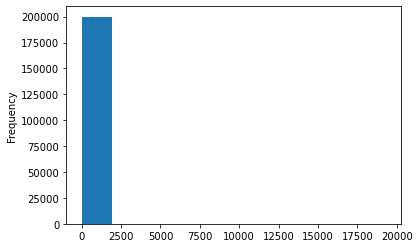

In [15]:
# 我们可以再构造一份特征给 LR NN 之类的模型用
# 之所以分开构造是因为，不同模型对数据集的要求不同
# 我们看下数据分布：
data['power'].plot.hist()

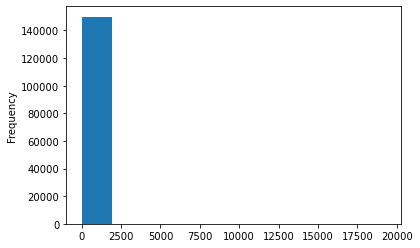

In [16]:
# 我们刚刚已经对 train 进行异常值处理了，但是现在还有这么奇怪的分布是因为 test 中的 power 异常值，
# 所以我们其实刚刚 train 中的 power 异常值不删为好，可以用长尾分布截断来代替
Train_data['power'].plot.hist()

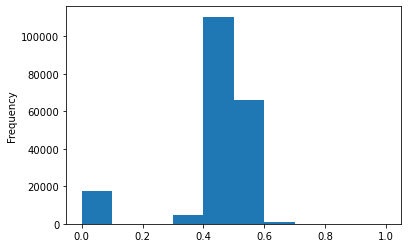

In [17]:
plt.cla()
# 我们对其取 log，在做归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['power'] = np.log(data['power'] + 1) 
data['power'] = ((data['power'] - np.min(data['power'])) / (np.max(data['power']) - np.min(data['power'])))
data['power'].plot.hist()

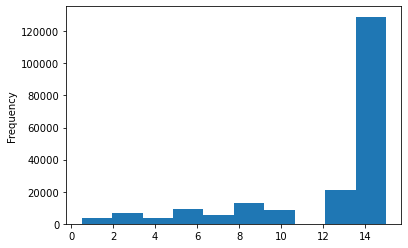

In [18]:
# km 的比较正常，应该是已经做过分桶了
data['kilometer'].plot.hist()

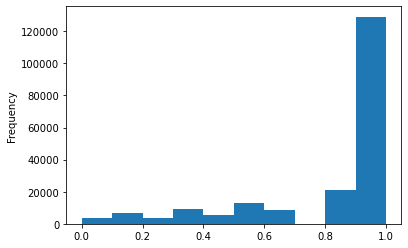

In [19]:
# 所以我们可以直接做归一化
data['kilometer'] = ((data['kilometer'] - np.min(data['kilometer'])) / 
                        (np.max(data['kilometer']) - np.min(data['kilometer'])))
data['kilometer'].plot.hist()

In [21]:
# 除此之外 还有我们刚刚构造的统计量特征：
# 'brand_amount', 'brand_price_average', 'brand_price_max',
# 'brand_price_median', 'brand_price_min', 'brand_price_std',
# 'brand_price_sum'
# 这里不再一一举例分析了，直接做变换，
def max_min(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

data['brand_amount'] = ((data['brand_amount'] - np.min(data['brand_amount'])) / 
                        (np.max(data['brand_amount']) - np.min(data['brand_amount'])))
data['brand_price_average'] = ((data['brand_price_average'] - np.min(data['brand_price_average'])) / 
                               (np.max(data['brand_price_average']) - np.min(data['brand_price_average'])))
data['brand_price_max'] = ((data['brand_price_max'] - np.min(data['brand_price_max'])) / 
                           (np.max(data['brand_price_max']) - np.min(data['brand_price_max'])))
data['brand_price_median'] = ((data['brand_price_median'] - np.min(data['brand_price_median'])) /
                              (np.max(data['brand_price_median']) - np.min(data['brand_price_median'])))
data['brand_price_min'] = ((data['brand_price_min'] - np.min(data['brand_price_min'])) / 
                           (np.max(data['brand_price_min']) - np.min(data['brand_price_min'])))
data['brand_price_std'] = ((data['brand_price_std'] - np.min(data['brand_price_std'])) / 
                           (np.max(data['brand_price_std']) - np.min(data['brand_price_std'])))
data['brand_price_sum'] = ((data['brand_price_sum'] - np.min(data['brand_price_sum'])) / 
                           (np.max(data['brand_price_sum']) - np.min(data['brand_price_sum'])))

In [20]:
# 对类别特征进行 OneEncoder
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType',
                                     'gearbox', 'notRepairedDamage', 'power_bin'])

In [21]:
print(data.shape)
data.columns

(200000, 369)


Index(['SaleID', 'name', 'power', 'kilometer', 'seller', 'offerType', 'price',
       'v_0', 'v_1', 'v_2',
       ...
       'power_bin_20.0', 'power_bin_21.0', 'power_bin_22.0', 'power_bin_23.0',
       'power_bin_24.0', 'power_bin_25.0', 'power_bin_26.0', 'power_bin_27.0',
       'power_bin_28.0', 'power_bin_29.0'],
      dtype='object', length=369)

In [24]:
# 这份数据可以给 LR 用
data.to_csv('fea-data/data_for_lr.csv', index=0)

## 3.3.3 特征筛选

### 1) 过滤式

DataFrame.corr(method='pearson', min_periods=1)  
参数说明：  
method：可选值为{‘pearson’, ‘kendall’, ‘spearman’}
1. pearson：Pearson相关系数来衡量两个数据集合是否在一条线上面，即针对线性数据的相关系数计算，针对非线性数据便会有误差。
2. kendall：用于反映分类变量相关性的指标，即针对无序序列的相关系数，非正太分布的数据
3. spearman：非线性的，非正太分析的数据的相关系数  
4. min_periods：样本最少的数据量

In [25]:
# 相关性分析
print(data['power'].corr(data['price'], method='spearman'))
print(data['kilometer'].corr(data['price'], method='spearman'))
print(data['brand_amount'].corr(data['price'], method='spearman'))
print(data['brand_price_average'].corr(data['price'], method='spearman'))
print(data['brand_price_max'].corr(data['price'], method='spearman'))
print(data['brand_price_median'].corr(data['price'], method='spearman'))

0.5773425426332196
-0.4097783640876424
0.05438301230221679
0.38875954584355615
0.2587402623951201
0.39159165603497703


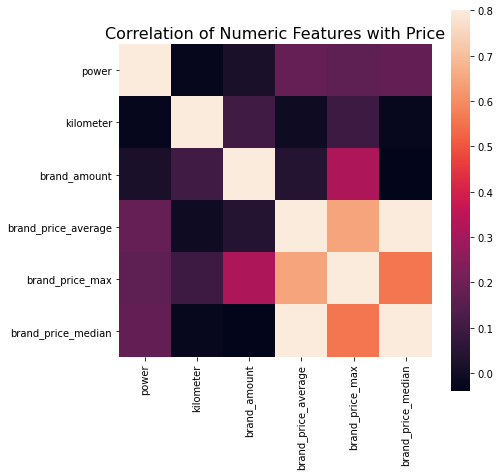

In [26]:
# 当然也可以直接看图
data_numeric = data[['power', 'kilometer', 'brand_amount', 'brand_price_average', 
                     'brand_price_max', 'brand_price_median']]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

### 2) 包裹式

In [32]:
# k_feature 太大会很难跑，没服务器，所以提前 interrupt 了
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
sfs = SFS(LinearRegression(),
           k_features=10,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
x = data.drop(['price'], axis=1)
x = x.fillna(0)
y = data['price']
sfs.fit(x, y)
sfs.k_feature_names_ 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# 画出来，可以看到边际效益
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.grid()
plt.show()

### 3) 嵌入式

In [ ]:
# 下一章介绍，Lasso 回归和决策树可以完成嵌入式特征选择
# 大部分情况下都是用嵌入式做特征筛选

## 3.4 经验总结

特征工程是比赛中最至关重要的的一块，特别的传统的比赛，大家的模型可能都差不多，调参带来的效果增幅是非常有限的，但特征工程的好坏往往会决定了最终的排名和成绩。

特征工程的主要目的还是在于将数据转换为能更好地表示潜在问题的特征，从而提高机器学习的性能。比如，异常值处理是为了去除噪声，填补缺失值可以加入先验知识等。

特征构造也属于特征工程的一部分，其目的是为了增强数据的表达。

有些比赛的特征是匿名特征，这导致我们并不清楚特征相互直接的关联性，这时我们就只有单纯基于特征进行处理，比如装箱，groupby，agg 等这样一些操作进行一些特征统计，此外还可以对特征进行进一步的 log，exp 等变换，或者对多个特征进行四则运算（如上面我们算出的使用时长），多项式组合等然后进行筛选。由于特性的匿名性其实限制了很多对于特征的处理，当然有些时候用 NN 去提取一些特征也会达到意想不到的良好效果。

对于知道特征含义（非匿名）的特征工程，特别是在工业类型比赛中，会基于信号处理，频域提取，丰度，偏度等构建更为有实际意义的特征，这就是结合背景的特征构建，在推荐系统中也是这样的，各种类型点击率统计，各时段统计，加用户属性的统计等等，这样一种特征构建往往要深入分析背后的业务逻辑或者说物理原理，从而才能更好的找到 magic。

当然特征工程其实是和模型结合在一起的，这就是为什么要为 LR NN 做分桶和特征归一化的原因，而对于特征的处理效果和特征重要性等往往要通过模型来验证。

总的来说，特征工程是一个入门简单，但想精通非常难的一件事。

## Task 3-特征工程 END.


--- By: 阿泽

    PS：复旦大学计算机研究生
    知乎：阿泽 https://www.zhihu.com/people/is-aze（主要面向初学者的知识整理）


关于Datawhale：

> Datawhale是一个专注于数据科学与AI领域的开源组织，汇集了众多领域院校和知名企业的优秀学习者，聚合了一群有开源精神和探索精神的团队成员。Datawhale 以“for the learner，和学习者一起成长”为愿景，鼓励真实地展现自我、开放包容、互信互助、敢于试错和勇于担当。同时 Datawhale 用开源的理念去探索开源内容、开源学习和开源方案，赋能人才培养，助力人才成长，建立起人与人，人与知识，人与企业和人与未来的联结。

本次数据挖掘路径学习，专题知识将在天池分享，详情可关注Datawhale：

![](http://jupter-oss.oss-cn-hangzhou.aliyuncs.com/public/files/image/1095279172547/1584432602983_kAxAvgQpG2.jpg) 
